<a href="https://colab.research.google.com/github/1000century/ml/blob/main/Algorithms/250205_%EA%B8%B0%EC%B4%88%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

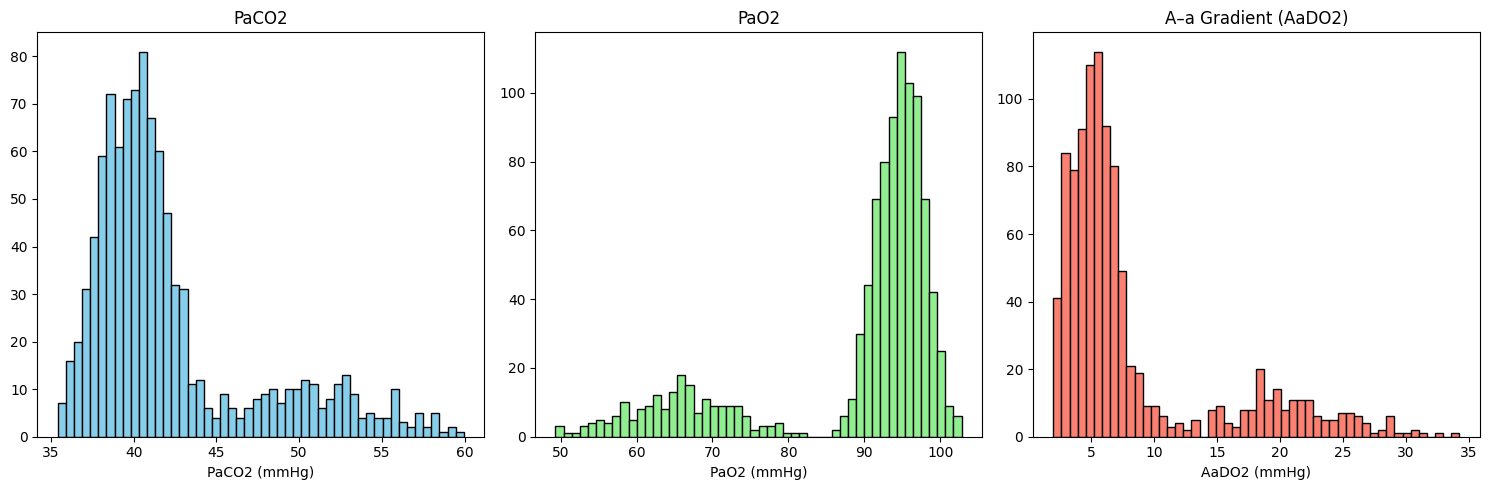

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# =============================================================================
# 도움 함수: truncated normal 샘플 생성
def get_truncated_normal(mean, sd, low, upp, size):
    a, b = (low - mean) / sd, (upp - mean) / sd
    return truncnorm(a, b, loc=mean, scale=sd).rvs(size)

# =============================================================================
# 설정 값
np.random.seed(42)  # 재현성을 위한 시드 설정
n_samples = 1000  # 전체 데이터 샘플 수

# 전체 인구의 80%는 정상군, 20%는 환자군으로 가정
n_healthy = int(n_samples * 0.8)
n_patients = n_samples - n_healthy

# 나이 생성 (20~80세 사이 랜덤 생성; 전체 샘플에 대해)
ages = np.random.randint(20, 81, size=n_samples)
# 각 집단에 대해 나이를 나눠줍니다.
ages_healthy = ages[:n_healthy]
ages_patients = ages[n_healthy:]

# =============================================================================
# 1. PaCO2 생성
# 정상군: PaCO2 평균 40, sd 2, 범위 [35, 45]
PaCO2_healthy = get_truncated_normal(mean=40, sd=2, low=35, upp=45, size=n_healthy)
# 환자군: PaCO2 평균 50, sd 5, 범위 [45, 60]
PaCO2_patients = get_truncated_normal(mean=50, sd=5, low=45, upp=60, size=n_patients)

# =============================================================================
# 2. 폐포 산소압 (PAO2) 계산: PAO2 = 150 - 1.25 * PaCO2
PAO2_healthy = 150 - 1.25 * PaCO2_healthy
PAO2_patients = 150 - 1.25 * PaCO2_patients

# =============================================================================
# 3. AaDO2 (A-a gradient) 생성
# 정상군: AaDO2 평균 5 mmHg, sd 2, 범위 [2, 12]
AaDO2_healthy = get_truncated_normal(mean=5, sd=2, low=2, upp=12, size=n_healthy)
# 환자군: AaDO2 평균 20 mmHg, sd 5, 범위 [10, 40]
AaDO2_patients = get_truncated_normal(mean=20, sd=5, low=10, upp=40, size=n_patients)

# =============================================================================
# 4. PaO2 계산: PaO2 = PAO2 - AaDO2
PaO2_healthy = PAO2_healthy - AaDO2_healthy
PaO2_patients = PAO2_patients - AaDO2_patients

# =============================================================================
# 5. 전체 데이터 결합
PaCO2_values = np.concatenate([PaCO2_healthy, PaCO2_patients])
PaO2_values = np.concatenate([PaO2_healthy, PaO2_patients])
AaDO2_values = np.concatenate([AaDO2_healthy, AaDO2_patients])
ages_all = np.concatenate([ages_healthy, ages_patients])

# 정상 A-a 기준 (나이별): (나이 / 4) + 4
normal_AaDO2_thresholds = (ages_all / 4) + 4

# 정상/비정상 라벨링 (여기서는 AaDO2 값이 나이별 정상 기준을 초과하면 '비정상'으로 라벨링)
labels = np.where(AaDO2_values > normal_AaDO2_thresholds, '1', '0')

# =============================================================================
# 6. 결과 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.title("PaCO2")
plt.hist(PaCO2_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("PaCO2 (mmHg)")

plt.subplot(1,3,2)
plt.title("PaO2")
plt.hist(PaO2_values, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel("PaO2 (mmHg)")

plt.subplot(1,3,3)
plt.title("A–a Gradient (AaDO2)")
plt.hist(AaDO2_values, bins=50, color='salmon', edgecolor='black')
plt.xlabel("AaDO2 (mmHg)")

plt.tight_layout()
plt.show()


In [2]:
# 데이터프레임 생성
data = {
    'Age': ages,
    'PaCO2': PaCO2_values,
    'PaO2': PaO2_values,
    'Label': labels
}
df = pd.DataFrame(data)

df

,Age,PaCO2,PaO2,Label
0,58,43.096884,92.955650,0
1,71,42.033006,93.898419,0
2,48,38.654077,95.620563,0
3,34,39.754529,96.744764,0
4,62,37.782463,97.486383,0
...,...,...,...,...
995,22,48.907119,66.469393,1
996,72,52.038747,60.134190,1
997,42,53.292512,65.854296,1
998,56,48.496528,78.328573,0


In [3]:
from sklearn.model_selection import train_test_split

# 특성과 라벨 분리
X = df[['Age', 'PaCO2', 'PaO2']]
y = df['Label']

# 훈련/테스트 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. 로지스틱 회귀모델 - 분류 문제용 모델

In [4]:
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

print("훈련 정확도:", model.score(X_train, y_train))
print(f"테스트 정확도: {model.score(X_test, y_test):.4f}")

훈련 정확도: 0.9975
테스트 정확도: 0.9950


## 2. SVM - 분류모델

In [5]:
from sklearn.svm import LinearSVC

# 선형 SVM 모델 훈련
model = LinearSVC()
model.fit(X_train, y_train)

print("훈련 정확도:", model.score(X_train, y_train))
print(f"테스트 정확도: {model.score(X_test, y_test):.4f}")

훈련 정확도: 0.97125
테스트 정확도: 0.9550


## 3. 결정 트리 - 분류 모델

훈련 세트 점수: 1.0
테스트 세트 점수: 0.965
훈련 세트 점수: 0.9825
테스트 세트 점수: 0.96


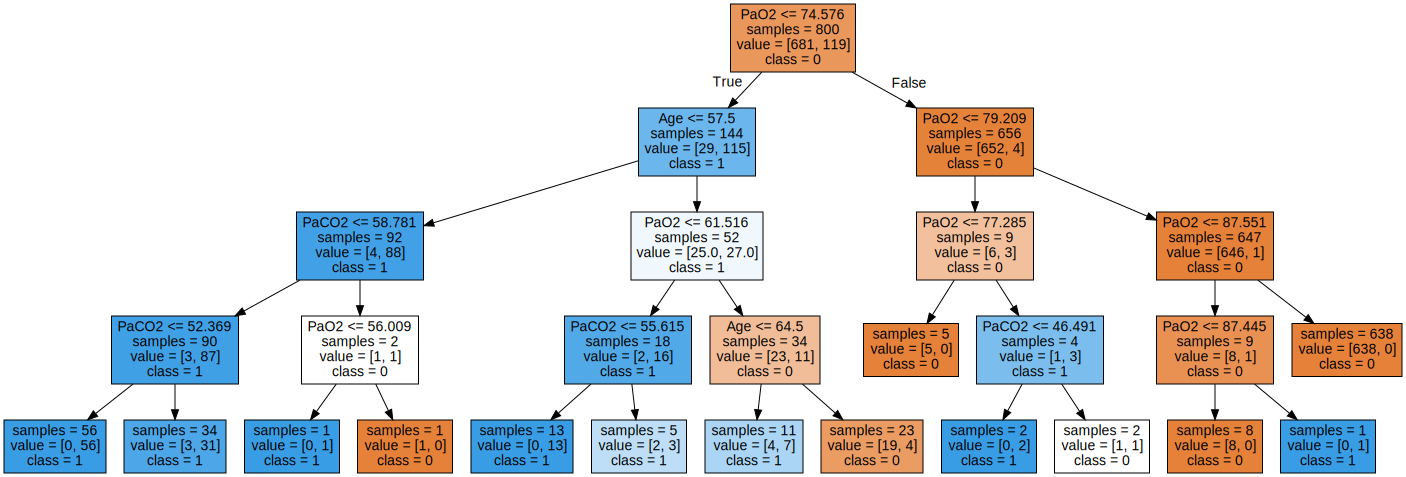

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

tree_model = DecisionTreeClassifier()
tree = tree_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {tree.score(X_train, y_train)}")
print(f"테스트 세트 점수: {tree.score(X_test, y_test)}")

export_graphviz(tree, out_file='tree.dot', class_names=['0', '1'], feature_names=['Age', 'PaCO2', 'PaO2'], impurity=False, filled=True)
with open('tree.dot') as f:
    dot_graph = f.read()
#display(graphviz.Source(dot_graph))


tree_model2 = DecisionTreeClassifier(max_depth=4)
tree2 = tree_model2.fit(X_train, y_train)

print(f"훈련 세트 점수: {tree2.score(X_train, y_train)}")
print(f"테스트 세트 점수: {tree2.score(X_test, y_test)}")

export_graphviz(tree2, out_file='tree.dot', class_names=['0', '1'], feature_names=['Age', 'PaCO2', 'PaO2'], impurity=False, filled=True)
with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


## 4. 앙상블 - RandomForest 분류기

훈련 세트 점수: 1.0
테스트 세트 점수: 0.965


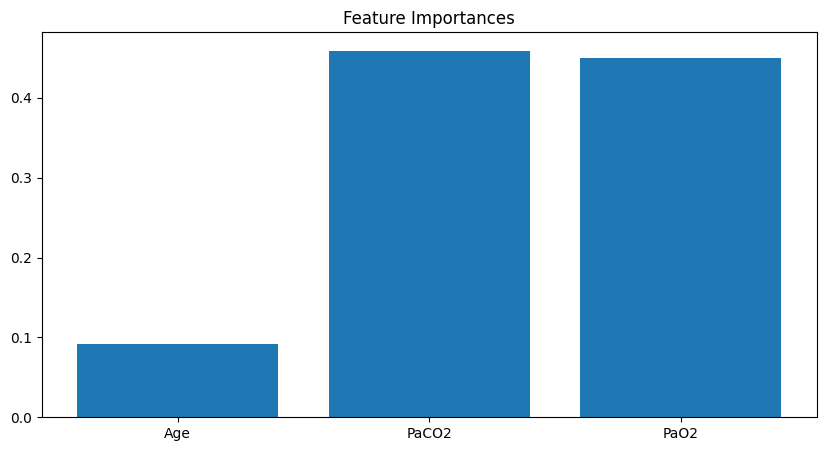

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest = forest_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {forest.score(X_train, y_train)}")
print(f"테스트 세트 점수: {forest.score(X_test, y_test)}")

importances = forest.feature_importances_

plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances)
plt.title("Feature Importances")
plt.show()

## 5. 그라디언트부스팅 분류기

훈련 세트 점수: 1.0
테스트 세트 점수: 0.97


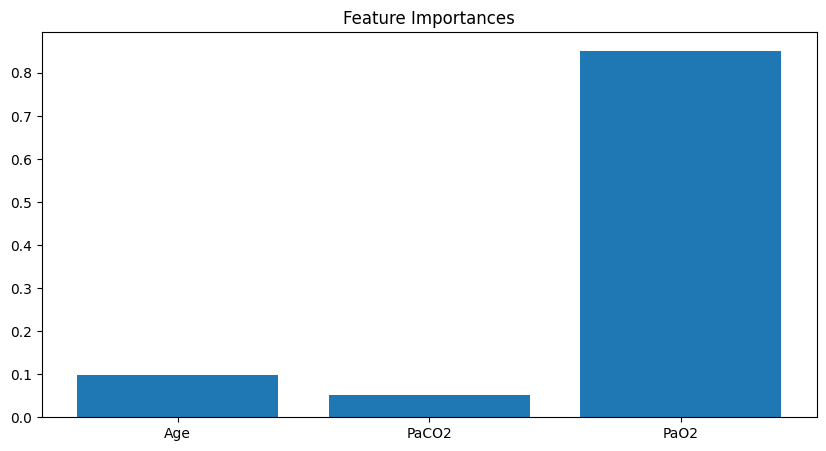

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb = gb_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {gb.score(X_train, y_train)}")
print(f"테스트 세트 점수: {gb.score(X_test, y_test)}")

importances = gb.feature_importances_

plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances)
plt.title("Feature Importances")
plt.show()

## 6. 배깅 분류기

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(LogisticRegression(), n_estimators=100, random_state=42)
bagging = bagging_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {bagging.score(X_train, y_train)}")
print(f"테스트 세트 점수: {bagging.score(X_test, y_test)}")


훈련 세트 점수: 0.9975
테스트 세트 점수: 0.995


## 7. 엑스트라 분류기

In [10]:
from sklearn.ensemble import ExtraTreesClassifier

x_tree = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_tree = x_tree.fit(X_train, y_train)

print(f"훈련 세트 점수: {extra_tree.score(X_train, y_train)}")
print(f"테스트 세트 점수: {extra_tree.score(X_test, y_test)}")



훈련 세트 점수: 1.0
테스트 세트 점수: 0.97


## 8. 아다부스트 분류기

In [11]:

from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost = adaboost_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {adaboost.score(X_train, y_train)}")
print(f"테스트 세트 점수: {adaboost.score(X_test, y_test)}")

훈련 세트 점수: 1.0
테스트 세트 점수: 0.97
